In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn
import os
import sys
import importlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
sys.path.append('../../model/')
from updatedModel import CATTransformer, train, test

# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

# df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/train.csv')
# df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/test.csv')
# df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/validation.csv') #READ FROM RIGHT SPOT

df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\train.csv')
df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\test.csv')
df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\validation.csv') #READ FROM RIGHT SPOT

#SET cat-columns TO NONE IF THERE ARE NO CATEGORICAL FEATURES
cat_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
target = ['income']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cat_columns + cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

cat_feat = [10,16,7,16,6,5,2,43]

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print(target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cat_columns, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.cate = df[cat_columns].astype(np.int64).values
        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cat_columns, cont_columns, 'income')
val_dataset = SingleTaskDataset(df_val, cat_columns, cont_columns, 'income')
test_dataset = SingleTaskDataset(df_test, cat_columns, cont_columns, 'income')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

GPU is available and being used
[2]


Epoch [ 1/75]        | Train: Loss 0.43018, Accuracy 0.79926                             | Test: Loss 0.34557, Accuracy 0.83860, F1 0.83550
Epoch [ 2/75]        | Train: Loss 0.32907, Accuracy 0.84706                             | Test: Loss 0.32744, Accuracy 0.84952, F1 0.84671
Epoch [ 3/75]        | Train: Loss 0.31656, Accuracy 0.85264                             | Test: Loss 0.32703, Accuracy 0.84907, F1 0.83308
Epoch [ 4/75]        | Train: Loss 0.30912, Accuracy 0.85586                             | Test: Loss 0.31178, Accuracy 0.85578, F1 0.84678
Epoch [ 5/75]        | Train: Loss 0.30382, Accuracy 0.85993                             | Test: Loss 0.31406, Accuracy 0.85680, F1 0.85469
Epoch [ 6/75]        | Train: Loss 0.30355, Accuracy 0.86013                             | Test: Loss 0.30833, Accuracy 0.85885, F1 0.85427
Epoch [ 7/75]        | Train: Loss 0.29822, Accuracy 0.86197                             | Test: Loss 0.30818, Accuracy 0.85714, F1 0.84661
Epoch [ 8/75]       

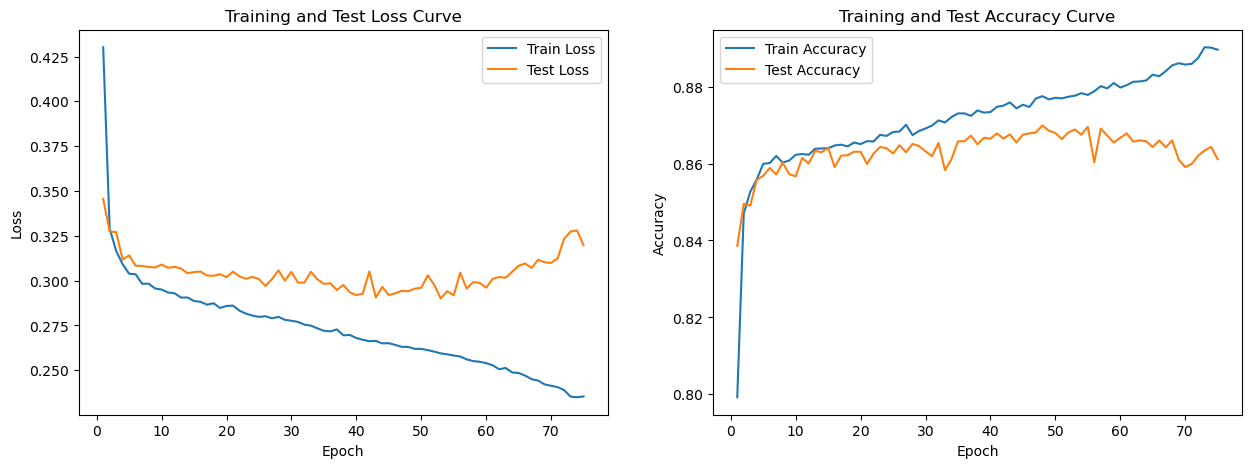

In [4]:
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       embedding_dropout=0.1,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       cat_feat=cat_feat).to(device_in_use)
class UncertaintyLoss(nn.Module):
    def __init__(self, num_tasks):
        super(UncertaintyLoss, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 75 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

Epoch [ 1/50]        | Train: Loss 0.42213, Accuracy 0.80266                             | Test: Loss 0.36327, Accuracy 0.82382, F1 0.82627
Epoch [ 2/50]        | Train: Loss 0.33510, Accuracy 0.84454                             | Test: Loss 0.32984, Accuracy 0.84804, F1 0.83980
Epoch [ 3/50]        | Train: Loss 0.31983, Accuracy 0.85080                             | Test: Loss 0.32487, Accuracy 0.85214, F1 0.84383
Epoch [ 4/50]        | Train: Loss 0.31069, Accuracy 0.85709                             | Test: Loss 0.31978, Accuracy 0.85441, F1 0.85291
Epoch [ 5/50]        | Train: Loss 0.30865, Accuracy 0.85653                             | Test: Loss 0.32150, Accuracy 0.84929, F1 0.84955
Epoch [ 6/50]        | Train: Loss 0.30417, Accuracy 0.85864                             | Test: Loss 0.31541, Accuracy 0.85896, F1 0.85258
Epoch [ 7/50]        | Train: Loss 0.30116, Accuracy 0.86048                             | Test: Loss 0.31473, Accuracy 0.85942, F1 0.85493
Epoch [ 8/50]       

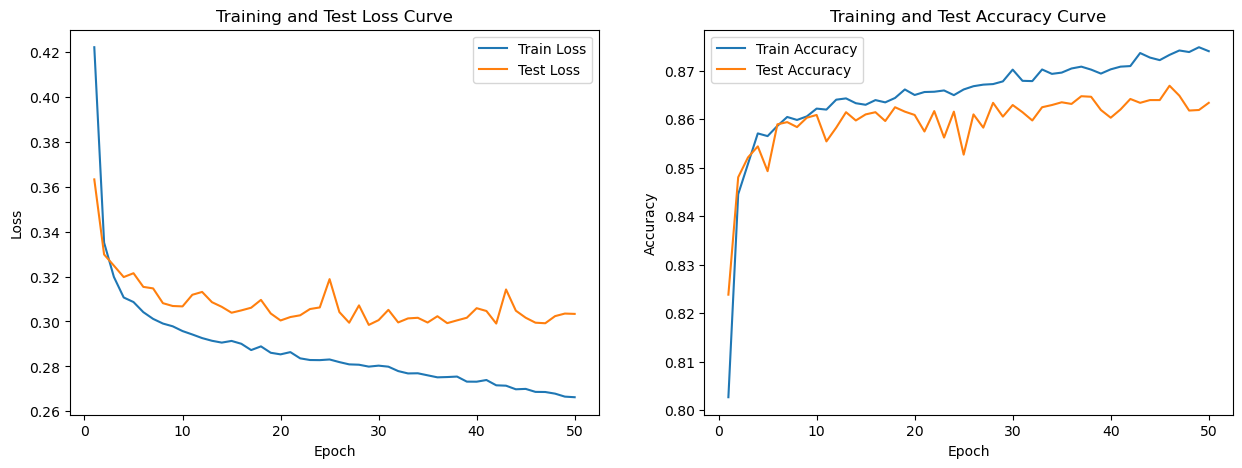

In [5]:
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       embedding_dropout=0.1,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       cat_feat=cat_feat).to(device_in_use)
class UncertaintyLoss(nn.Module):
    def __init__(self, num_tasks):
        super(UncertaintyLoss, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.AdamW(params=model.parameters(), lr = 0.0001, weight_decay=0.00001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 50 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)